## Causal Tracing (ROME)

Causal tracing was a methodology for locating where facts are stored in transformer LMs, introduced in the paper ["Locating and Editing Factual Associations in GPT" (Meng et al., 2023)](https://arxiv.org/abs/2202.05262). In this notebook, we will implement their method using this library and replicate the first causal tracing example in the paper (full figure 1 on page 2).

In [1]:
from typing import List

from datasets import load_dataset
import torch
import pandas as pd
import numpy as np
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    VanillaIntervention, Intervention,
    RepresentationConfig,
    IntervenableConfig,
    ConstantSourceIntervention,
    LocalistRepresentationIntervention
)
from pyvene import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    xlab, ylab, ylim,
    scale_y_discrete, scale_y_continuous, ggsave
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm

titles={
    "block_output": "single restored layer in GPT2-XL",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
}

In [2]:
# format_token()

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
config, tokenizer, gpt = create_gpt2(name="gpt2-xl")
gpt.to(device)

# base = "The Space Needle is in downtown"
base = "The name of the best football player in history is"
inputs = [
    tokenizer(base, return_tensors="pt").to(device),
]
print(base)
res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

loaded model
The name of the best football player in history is
_not                 0.04776443913578987
_a                   0.03196384012699127
_the                 0.0173189677298069
_often               0.01677759736776352
_Michael             0.015544882044196129
_"                   0.01474055740982294
_usually             0.014530271291732788
_Lionel              0.011356345377862453
,                    0.010532096028327942
_still               0.01006372645497322


## Corrupted run

The first step in implementing causal tracing is to corrupt the input embeddings for the subject tokens by adding Gaussian noise to them. In Meng et al., the standard deviation of the Gaussian we sample from is computed as thrice the standard deviation of embeddings over a big dataset. We encode this as a constant, `self.noise_level`.

Note that the `source` argument is ignored unlike in causal interventions, since we are adding noise without reference to any other input.

Our intervention config intervenes on the `block_input` of the 0th layer, i.e. the embeddings.

In [8]:
class NumCorruptedTokens:
    num_corrupted_tokens = 4

In [9]:
class NoiseIntervention(ConstantSourceIntervention, LocalistRepresentationIntervention):
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = embed_dim
        rs = np.random.RandomState(1)
        prng = lambda *shape: rs.randn(*shape)
        self.noise = torch.from_numpy(
            prng(1, NumCorruptedTokens.num_corrupted_tokens, embed_dim)).to(device)
        self.noise_level = 0.13462981581687927

    def forward(self, base, source=None, subspaces=None):
        base[..., : self.interchange_dim] += self.noise * self.noise_level
        return base

    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.embed_dim})"


def corrupted_config(model_type):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                0,              # layer
                "block_input",  # intervention type
            ),
        ],
        intervention_types=NoiseIntervention,
    )
    return config

In [10]:
base = tokenizer("The capital of Poland is", return_tensors="pt").to(device)
config = corrupted_config(type(gpt))
intervenable = IntervenableModel(config, gpt)
_, counterfactual_outputs = intervenable(
    base, unit_locations={"base": ([[[0, 1, 2, 3]]])}
)
distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

_a                   0.20069493353366852
_the                 0.11948681622743607
_not                 0.03683437407016754
_an                  0.03086451068520546
_one                 0.022700533270835876
_in                  0.021483222022652626
_to                  0.01945047825574875
_now                 0.0124002480879426
_going               0.007659939583390951
_my                  0.00696560088545084


### Restored run

We now make a config that performs the following:
1. Corrupt input embeddings for some positions.
2. Restore the hidden state at a particular layer for some (potentially different positions).

This is how Meng et al. check where in the model the fact moves through.

In [11]:
def restore_corrupted_with_interval_config(
    layer, stream="mlp_activation", window=10, num_layers=48):
    start = max(0, layer - window // 2)
    end = min(num_layers, layer - (-window // 2))
    config = IntervenableConfig(
        representations=[
            RepresentationConfig(
                0,       # layer
                "block_input",  # intervention type
            ),
        ] + [
            RepresentationConfig(
                i,       # layer
                stream,  # intervention type
        ) for i in range(start, end)],
        intervention_types=\
            [NoiseIntervention]+[VanillaIntervention]*(end-start),
    )
    return config

In [12]:
def get_activations(base, token, model, config, corrupted_positions=[0, 1, 2, 3]):
    for stream in ["block_output", "mlp_activation", "attention_output"]:
        data = []
        for layer_i in tqdm(range(model.config.n_layer)):
            for pos_i in range(len(base.input_ids[0])):
                config = restore_corrupted_with_interval_config(
                    layer_i, stream,
                    window=1 if stream == "block_output" else 10
                )
                n_restores = len(config.representations) - 1
                intervenable = IntervenableModel(config, model)
                _, counterfactual_outputs = intervenable(
                    base,
                    [None] + [base]*n_restores,
                    {
                        "sources->base": (
                            [None] + [[[pos_i]]]*n_restores,
                            [[corrupted_positions]] + [[[pos_i]]]*n_restores,
                        )
                    },
                )
                distrib = embed_to_distrib(
                    model, counterfactual_outputs.last_hidden_state, logits=False
                )
                prob = distrib[0][-1][token].detach().cpu().item()
                data.append({"layer": layer_i, "pos": pos_i, "prob": prob})
        df = pd.DataFrame(data)
        df.to_csv(f"./tutorial_data/pyvene_rome_{stream}.csv")

In [13]:
def plot_activations(token: str, custom_labels: List[str] = ["The", "capital", "of", "Poland", "is"]):
    token = token.strip()
    for stream in ["block_output", "mlp_activation", "attention_output"]:
        df = pd.read_csv(f"./tutorial_data/pyvene_rome_{stream}.csv")
        df["layer"] = df["layer"].astype(int)
        df["pos"] = df["pos"].astype(int)
        df[f"p({token})"] = df["prob"].astype(float)

        breaks = [i for i in range(len(custom_labels))]

        plot = (
            ggplot(df, aes(x="layer", y="pos"))

            + geom_tile(aes(fill=f"p({token})"))
            + scale_fill_cmap(colors[stream]) + xlab(titles[stream])
            + scale_y_reverse(
                limits = (-0.5, 6.5),
                breaks=breaks, labels=custom_labels)
            + theme(figure_size=(5, 4)) + ylab("")
            + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
        )
        ggsave(
            plot, filename=f"./tutorial_data/pyvene_rome_{stream}.pdf", dpi=200
        )
        display(plot)

In [14]:
def get_results(sentence: str, word: str, model: torch.nn.Module, config, tokenizer, corrupted_positions=[0, 1, 2, 3]):
    token = tokenizer.encode(word)[0]
    base = tokenizer(sentence, return_tensors="pt").to(device)
    # inputs = [base]
    # res = gpt(**inputs[0])
    # distrib = embed_to_distrib(model, res.last_hidden_state, logits=False)
    # top_vals(tokenizer, distrib[0][-1], n=10)
    get_activations(base, token, model, config, corrupted_positions)
    plot_activations(word, sentence.split(" "))

In [15]:
def get_yes_and_no_results(question, gpt, config, tokenizer, corrupted_positions):
    get_results(question, " Yes", gpt, config, tokenizer, corrupted_positions=corrupted_positions)
    get_results(question, " No", gpt, config, tokenizer, corrupted_positions=corrupted_positions)

In [16]:
ds = load_dataset("google/boolq")

In [17]:
question = ds["train"]["question"][0]
question

'do iran and afghanistan speak the same language'

100%|██████████| 48/48 [02:28<00:00,  3.10s/it]
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_block_output.pdf
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 192 rows containing missing values.
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 192 rows containing missing values.


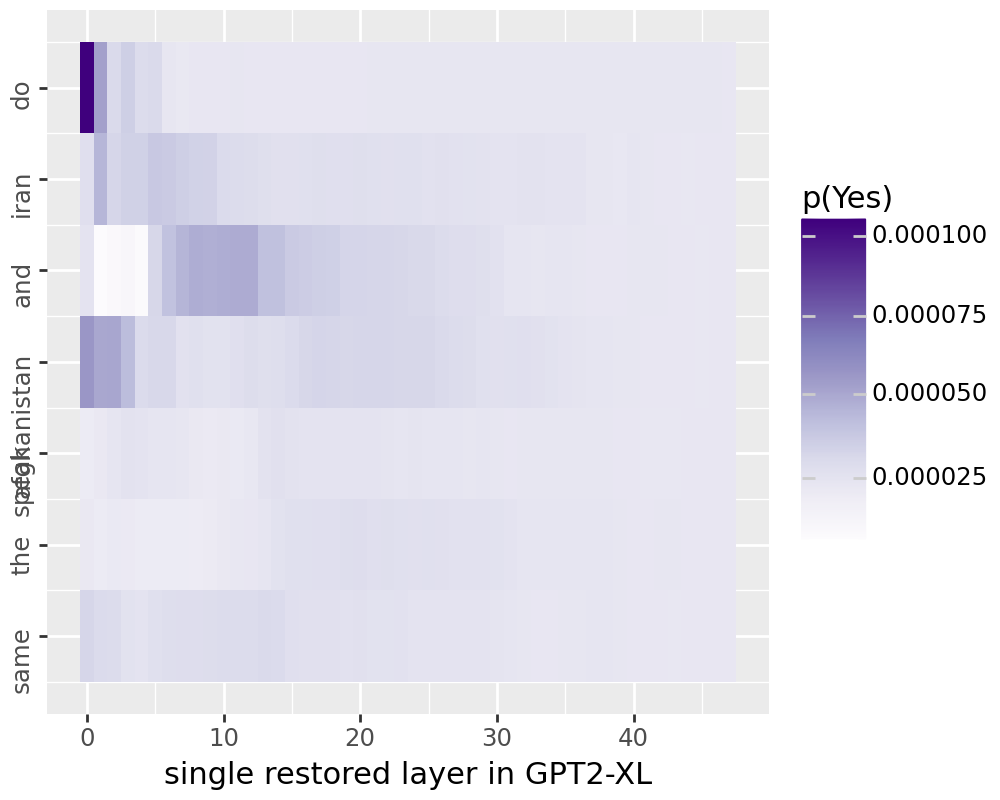

/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_mlp_activation.pdf
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 192 rows containing missing values.
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 192 rows containing missing values.


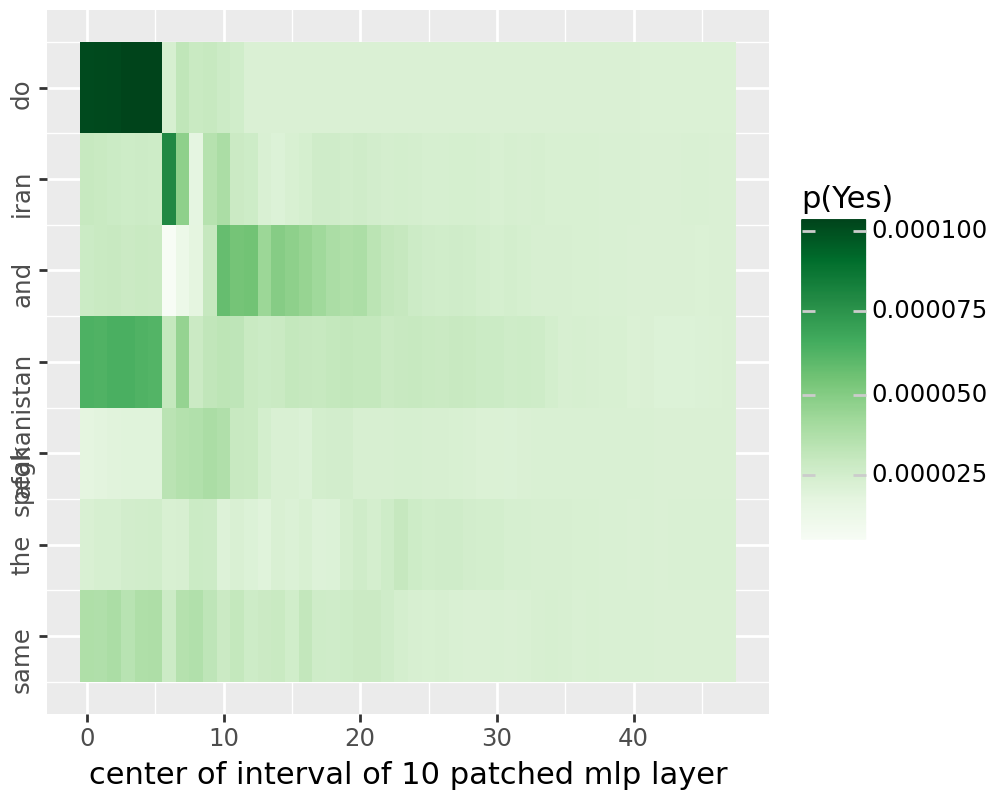

/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_attention_output.pdf
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 192 rows containing missing values.
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 192 rows containing missing values.


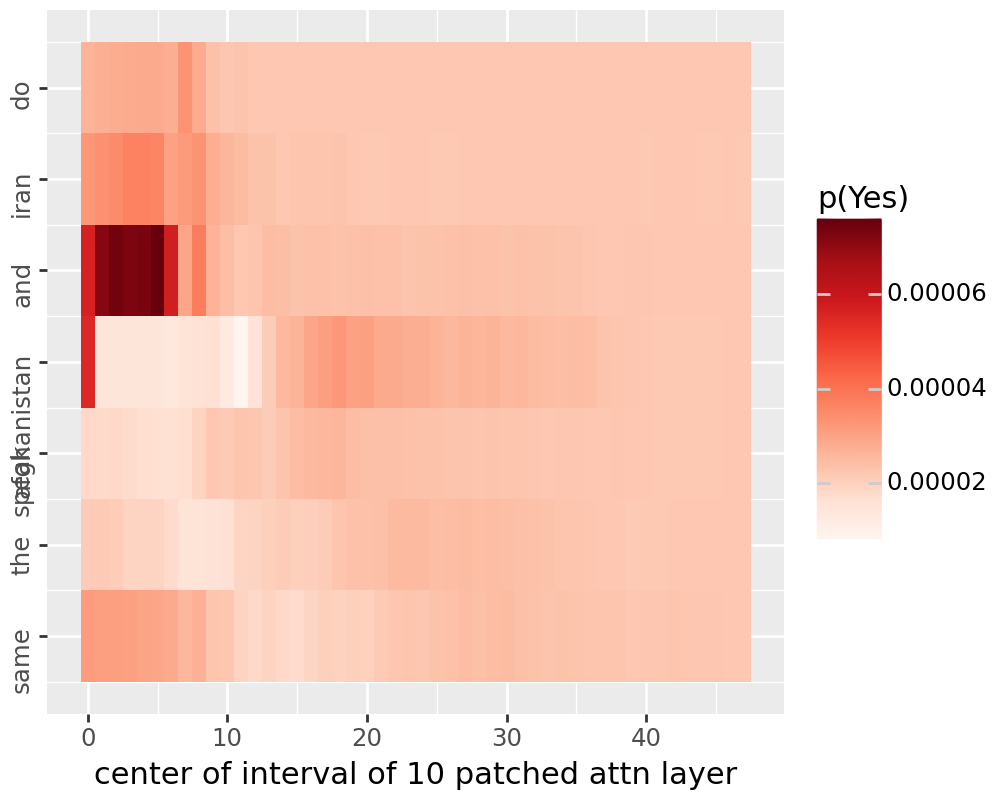

100%|██████████| 48/48 [02:27<00:00,  3.08s/it]
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_block_output.pdf
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 192 rows containing missing values.
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 192 rows containing missing values.


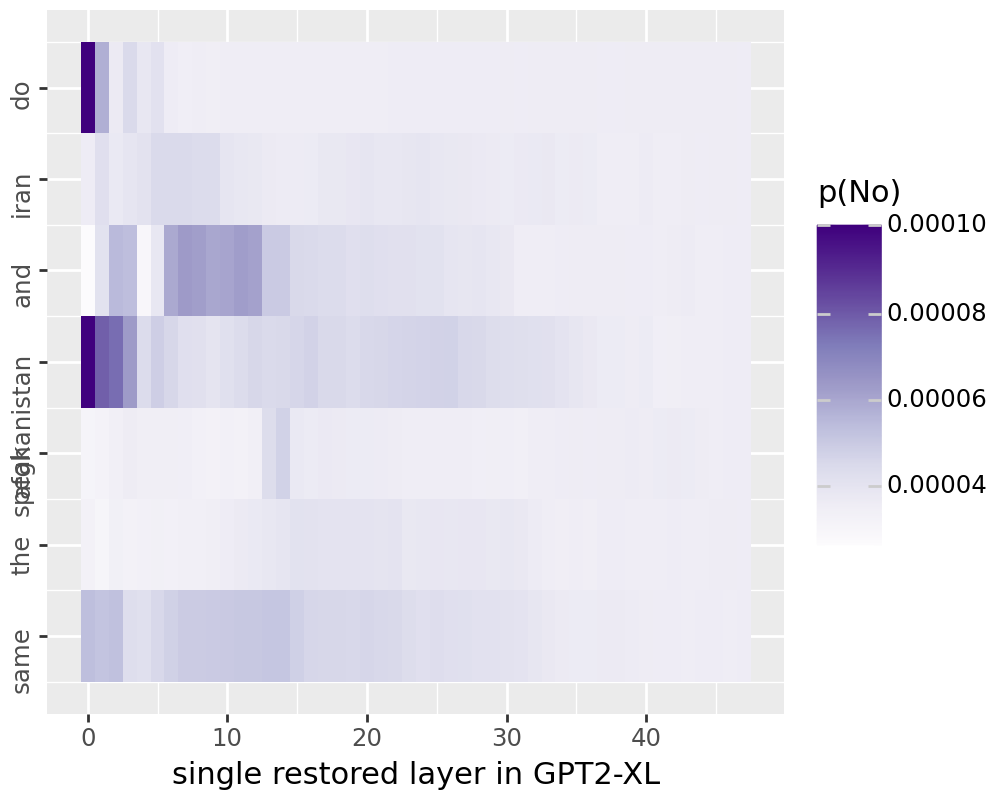

/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_mlp_activation.pdf
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 192 rows containing missing values.
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 192 rows containing missing values.


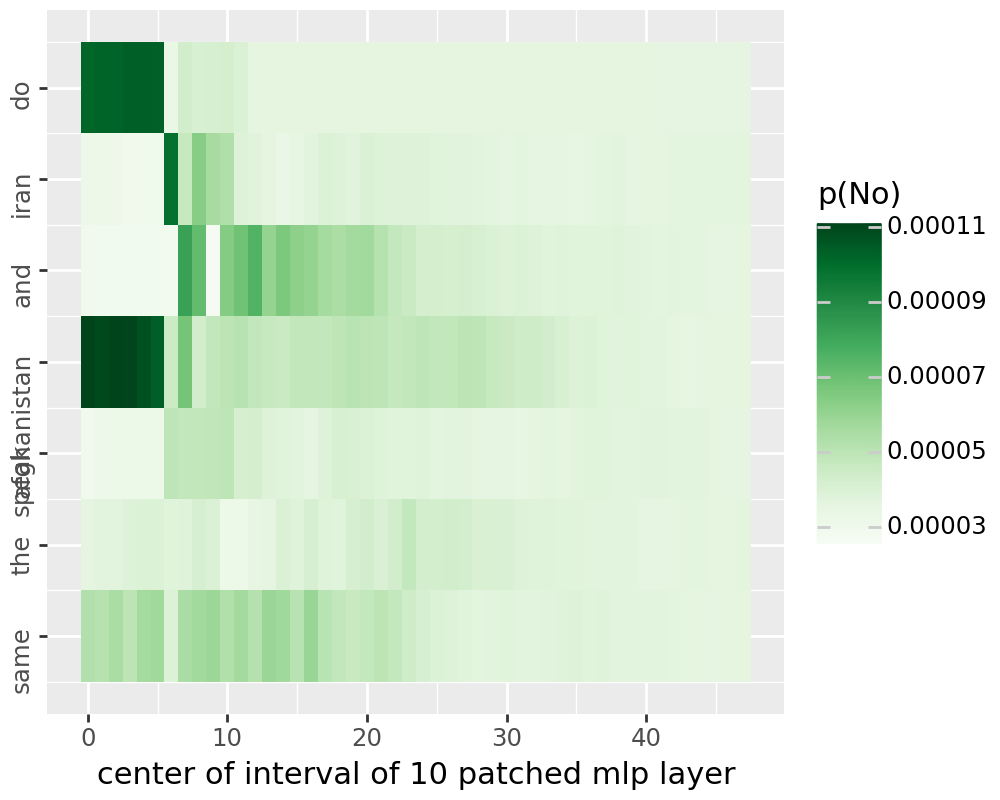

/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_attention_output.pdf
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 192 rows containing missing values.
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 192 rows containing missing values.


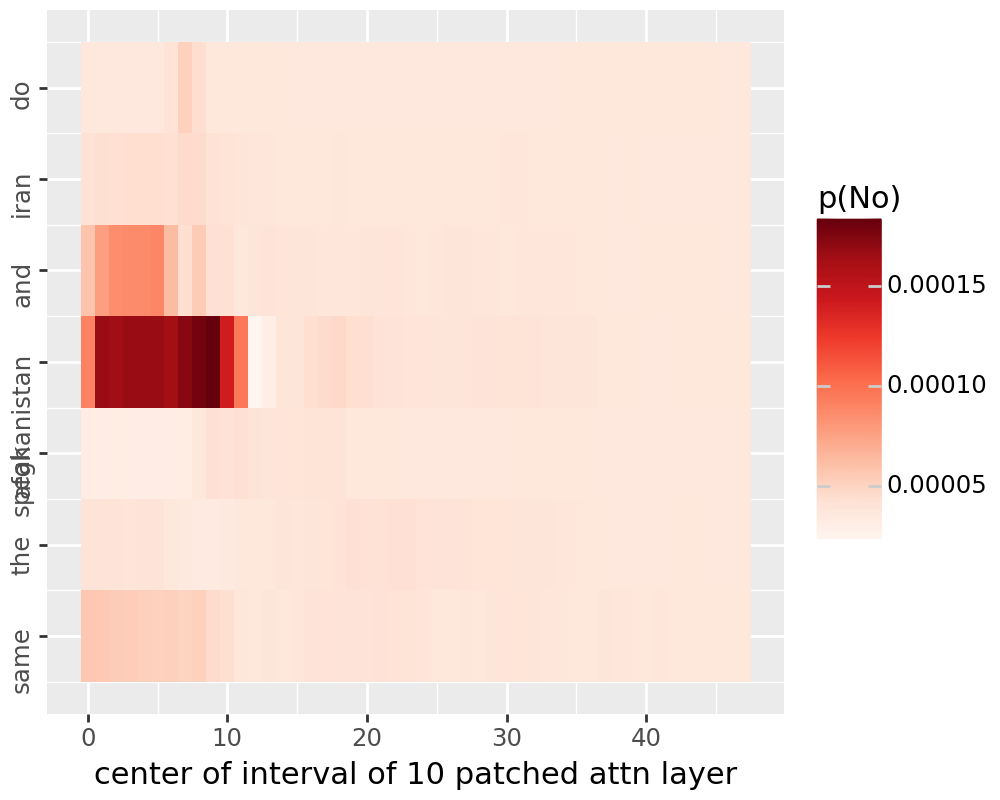

In [19]:
NumCorruptedTokens.num_corrupted_tokens = 8
get_yes_and_no_results(question, gpt, config, tokenizer, corrupted_positions=[0, 1, 2, 3, 4, 5, 6, 7])